# SCCA with Application to Finance Data

This notebook details a comparison between company earnings data and stock prices through sparse canonical correlation analysis (SCCA). After pulling the data, we will introduce the algorithm for performing the analysis, and walk through each set of results. 

## Data Pulling

In [53]:
def group_quarters(timelist):
    '''
    input: list of datetime objects from dataframe
    
    output: rounded list of datetime objects snapped to fixed quarter dates
    
    fixed dates (make sure not weekends, holidays)
    '''
#    qdates = ['0331', '0630', '0930', '1231']
    qdates = [331, 630, 930, 1231] #can't have 0 in front of month
    q1, q2, q3, q4 =  qdates
    
    new_ind = [] #replacement quarter-based index
    for date in timelist:
        qlab = ''
        numdate = int(pd.datetime.strftime(date, '%m%d'))
        year = date.year
        if q1 <= numdate <= q2:
            qlab = 'Q1'
        elif q2 <= numdate <= q3:
            qlab = 'Q2'
        elif q3 <= numdate <= q4:
            qlab = 'Q3'
        elif q4 <= numdate or numdate <= q1: 
            qlab = 'Q4'
        new_ind.append(f'{year} {qlab}')
    return new_ind

In [56]:
#pull stock data
import pandas as pd
import random as rd
from glob import glob #for importing multiple csv's of same parent path
from numpy import log #default base is e (natural log)
import os.path
from os import path #to check valid file paths

#0) Pull list of SP500 tickers
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp5 = table[0]
tickers = list(sp5['Symbol'])
rd.seed(30) #use seed for reproducable experiment
stocks = rd.sample(tickers, 100)

stable_ticks = set() #keep track of tickers that exist in stooq set

#finding the path
#parent_path = 'C:/Users/Zion/Desktop/CorroTrack/stooq_d_us_txt/data/daily/us/nasdaq stocks/1/' #don't need full local path
parent_path = 'stooq_d_us_txt/data/daily/us/nasdaq stocks/' #all sp500 should be on the nasdaq
alt_path = 'stooq_d_us_txt/data/daily/us/nasdaq stocks/'
def fill_stocks():
    count = 0
    table = pd.DataFrame()
    for stock in stocks:
        if path.isfile(f'{parent_path}1/{stock}.us.txt'): #if valid file path
            stock_df = pd.read_csv(f'{parent_path}1/{stock}.us.txt')
            stable_ticks.add(stock)
        elif path.isfile(f'{parent_path}2/{stock}.us.txt'): #might be in other folder
            stock_df = pd.read_csv(f'{parent_path}2/{stock}.us.txt')
            stable_ticks.add(stock)
        else: #stooq doesnt contain data
            continue
        
        stock_df.drop(['<PER>', '<TIME>', '<VOL>', '<OPENINT>'], axis=1, inplace = True)

        #computing calculated values
        stock_df['Volatility'] = (0.361*(log(stock_df['<HIGH>']) - log(stock_df['<LOW>']))**2)**(0.5)
        stock_df['Return'] = (stock_df['<CLOSE>'] - stock_df['<OPEN>'])/stock_df['<OPEN>']*100

    
        times = pd.to_datetime(stock_df['<DATE>'], format ='%Y%m%d')
        
        #3) use ticker name to change the remaining columns
        c = stock_df.pivot(index='<TICKER>', columns = '<DATE>')
        
        #rename the columns somehow (like "AUSTRIA_Liquid Fuel")
        new = c.stack(0).transpose()
        new.columns = ['__'.join(col).strip() for col in new.columns.values]
        new.index = times.dt.strftime("%Y-%m-%d") #need to do the year first so index sorts correctly
        new = new[new.index >= "2015-01-01"] #crop this 
        if table.empty:
            table = new
        else: #ready to merge
            table=pd.merge(table, new, how='outer', on='<DATE>') #CHANGE IT TO MERGE ON OUTER BUT GO 5 YRS BACK
        count += 1
        print(f'Progress: {count} / {len(stocks)}')

    #Quarter condensing
    dtimes = pd.to_datetime(table.index, format ="%Y-%m-%d")
    table.index = group_quarters(dtimes) #need to cast back to a datetime object
    table.index.name = 'quarter'
    table = table.groupby(by="quarter").mean()
    table.sort_index(inplace = True)
    table = table.reindex(sorted(table.columns), axis=1)

    #filter out desired vars
    close_prices = table.filter(like='<CLOSE>', axis=1)
    volatility = table.filter(like='Volatility', axis=1)

    return table, close_prices, volatility

try:
    if stock_table.empty:
        stock_table, cp, vol = fill_stocks()
except: #stock_table doesn't exist
    stock_table, cp, vol = fill_stocks()

print(stock_table.head())

Progress: 1 / 100
Progress: 2 / 100
Progress: 3 / 100
Progress: 4 / 100
Progress: 5 / 100
Progress: 6 / 100
Progress: 7 / 100
Progress: 8 / 100
Progress: 9 / 100
Progress: 10 / 100
Progress: 11 / 100
Progress: 12 / 100
Progress: 13 / 100
Progress: 14 / 100
Progress: 15 / 100
Progress: 16 / 100
Progress: 17 / 100
Progress: 18 / 100
Progress: 19 / 100
Progress: 20 / 100
Progress: 21 / 100
Progress: 22 / 100
Progress: 23 / 100
Progress: 24 / 100
Progress: 25 / 100
         ABMD.US__<CLOSE>  ABMD.US__<HIGH>  ABMD.US__<LOW>  ABMD.US__<OPEN>  ...  VRTX.US__<LOW>  VRTX.US__<OPEN>  VRTX.US__Return  VRTX.US__Volatility
quarter                                                                      ...                                                                       
2015 Q1         66.520469        67.579266       65.419047        66.728594  ...      124.092381       125.993492        -0.068601             0.017977
2015 Q2         88.110937        89.861562       86.030156        87.845781  .

In [57]:
#pull earnings data
import datetime
import json #to manipulate yec output
import pandas as pd
from yahoo_earnings_calendar import YahooEarningsCalendar

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 1000)

yec = YahooEarningsCalendar()

def pull_earnings(dtype = 'epssurprisepct'):
    earn_table= pd.DataFrame()
    prog = 0
    for stock in stable_ticks: #only pull earnings for valid stooq companies
        #only have to save the df once
        try:
            edf = pd.read_json(f'earnings/{stock}.json') #earnings data frame
        except: #dataframe doesn't exist yet    
            earnings = yec.get_earnings_of(stock)

            def save_json(data, stock): #pass in stock name and json    
                with open(f'earnings/{stock}.json', 'w') as json_file:
                    json.dump(data, json_file)

            save_json(earnings, stock)

            edf = pd.read_json(f'earnings/{stock}.json') #earnings data frame

        cropped_edf = edf[[dtype,'startdatetime', 'ticker']]

        #3) use ticker name to change the remaining columns
        #pivot_table = generalization of pivot that can aggregate duplicates
        c = cropped_edf.pivot_table(index='ticker', columns = 'startdatetime', aggfunc='mean')

        #rename the columns somehow (like "AUSTRIA_Liquid Fuel")
        new = c.stack(0).transpose()
        new.columns = ['__'.join(col).strip() for col in new.columns.values]
        dates = pd.to_datetime(new.index, format ='%Y-%m-%dT%H:%M:%S.%fZ')
        new.index = group_quarters(dates)
        new = new[new.index >= "2015 Q1"] #crop this 
        print(new.tail())

        if earn_table.empty:
            print('NO MERGE')
            earn_table = new
        else: #ready to merge
            print('MERGE')
            earn_table=pd.merge(earn_table, new, how='outer', left_index=True, right_index=True)#, on='startdatetime') #CHANGE IT TO MERGE ON OUTER BUT GO 5 YRS BACK
        prog += 1
        print(f'Progress: {prog} / {len(stable_ticks)}')

    earn_table.index.name = 'quarter'
    earn_table = earn_table.groupby(by="quarter").mean()
    earn_table = earn_table.reindex(sorted(earn_table.columns), axis=1)

    print(earn_table.tail(50))
    return earn_table

earn_table = pull_earnings(dtype = 'epsestimate')


         DISCK__epsestimate
2019 Q3                0.82
2020 Q4                0.92
2020 Q1                0.84
2020 Q2                0.71
2020 Q3                0.64
NO MERGE
Progress: 1 / 25
         VRSN__epsestimate
2019 Q3               1.31
2020 Q4               1.33
2020 Q1               1.28
2020 Q2               1.27
2020 Q3               1.25
MERGE
Progress: 2 / 25
         SBUX__epsestimate
2019 Q3               0.70
2020 Q4               0.76
2020 Q1               0.34
2020 Q2              -0.59
2020 Q3               0.29
MERGE
Progress: 3 / 25
         DXCM__epsestimate
2019 Q3               0.20
2020 Q4               0.74
2020 Q1               0.14
2020 Q2               0.35
2020 Q3               0.64
MERGE
Progress: 4 / 25
         CTAS__epsestimate
2019 Q2               2.15
2019 Q3               2.03
2020 Q4               2.02
2020 Q2               1.21
2020 Q2               2.11
MERGE
Progress: 5 / 25
         QCOM__epsestimate
2019 Q3               0.71
2020 Q4     

## Experiments

Now that the earnings and stock prices has been extracted and formatted, we can analyze the data using SCCA. We find sparse canonical vectors by optimizing over: 

The lasso estimates the canonical vectors **w** and **e** by minimizing the following objective: 

$$\min_{\textbf{w}, \textbf{e}} |X^\top \textbf{w} - Y^\top \textbf{e}|^2 + \mu |\textbf{w}|_1 + \gamma |\textbf{e}|_1$$

We solve this via a biconvex iterative approach: first, fix $\mathbf{e}$, then minimize:
$$\min_{\textbf{w}} |X^\top \textbf{w} - Y^\top \textbf{e}|^2 + \mu |\textbf{w}|_1$$
to solve for **w**. Given this **w**, solve the symmetric objective to get **e**.



### Experiment 1

The first experiment applies the SCCA algorithm to analyze the data from above. This is an introductory comparison between stock prices and earnings data. Often times, when stock prices are analyzed, earnings data is overlooked because it’s a different data type. However, since both stock prices and earnings data describe company performance, integrating both sources in data analysis can actually create a fuller picture of price action.

In [151]:
#trying cvxopt algorithm - SCCA DJ Algo 5
from cvxopt import matrix, solvers
from scipy import stats
from l1regls import *
import numpy as np

x1 = matrix(cp.fillna(cp.mean()).to_numpy()) #(23, 13)
x2 =  matrix(earn_table.fillna(earn_table.mean()).to_numpy()[:x1.size[0], :])

def dual_lasso(X1=x1, X2=x2, mu=7, gam=2):
    n = X1.size[1]
    print('debug', X1.size)
    print('debug', X2.size)

    #2) Define opt fcns & params
    e = matrix(np.random.rand(n,1))
    w = matrix(np.random.rand(n,1))
    K = X2.T #use X2 instead of a kernel

    # STEP 1: [DO THE L1 ALTERNATING NORM HERE]
    eps = 0.0001*np.ones(n)
    dw, de= matrix(0.5*np.ones(n)), matrix(0.5*np.ones(n)) #deltas to judge convergence
    #mu,gam = 100, 140 #experiment with these

    w_old, e_old = w,e
    #repeat until within error tolerance
    #multiply by 1/mu to get the proper form
    while np.greater_equal(dw, eps).all() or np.greater_equal(de, eps).all():
        #fix e, find w
        w_new = l1regls((1/mu)*X1, (1/mu)*X2*e_old) #|X1'w - y| + u|w| 
        #fix w, find e
        e_new = l1regls((1/gam)*X2, (1/gam)*X1*w_new)
        #compute deltas
        dw = np.absolute(w_new-w_old)
        de = np.absolute(e_new-e_old)
        #reset vars        
        w_old, e_old = w_new, e_new

    w,e = w_new, e_new    
    #3) Solve with CVXOpt
    print('answer: ', np.round(np.array(w),2))
    print(np.round(np.array(e),2))

    corr = stats.pearsonr(X1*w, X2*e)[0]
    print('CORRELATION: ', corr)

    return w,e

w,e = dual_lasso(mu = 7, gam = 2)
    

debug (23, 25)
debug (23, 25)
A.T size:  (25, 23) b size:  (23, 1)
A.T*b =   (25, 1)
     pcost       dcost       gap    pres   dres
 0: -9.1221e+01 -7.8678e+01  3e+01  1e+01  2e-11
 1: -7.9348e+01 -7.8652e+01  2e+00  6e-01  9e-13
 2: -7.8608e+01 -7.8558e+01  2e-01  8e-02  1e-13
 3: -7.8493e+01 -7.8497e+01  4e-02  9e-03  9e-15
 4: -7.8488e+01 -7.8489e+01  2e-03  1e-04  3e-15
 5: -7.8489e+01 -7.8489e+01  2e-04  5e-06  2e-13
 6: -7.8489e+01 -7.8489e+01  7e-06  5e-08  1e-13
Optimal solution found.
A.T size:  (25, 23) b size:  (23, 1)
A.T*b =   (25, 1)
     pcost       dcost       gap    pres   dres
 0: -9.7324e+02 -9.0274e+02  3e+02  2e+01  2e-02
 1: -9.2262e+02 -9.5600e+02  3e+01  2e-15  3e-16
 2: -9.5105e+02 -9.5470e+02  4e+00  2e-15  3e-15
 3: -9.5371e+02 -9.5401e+02  3e-01  3e-15  1e-14
 4: -9.5394e+02 -9.5397e+02  3e-02  9e-16  4e-14
 5: -9.5396e+02 -9.5396e+02  1e-03  2e-15  6e-14
 6: -9.5396e+02 -9.5396e+02  2e-05  9e-16  1e-12
Optimal solution found.
A.T size:  (25, 23) b size:  (

In [153]:
# interpreting w and e
basket = list(stable_ticks)
basket.sort()

def stock_conversion(vec, stock_basket=basket):
    '''
    input: w, e vector
    output: list of corresponding stocks sorted in order of canonical weights
    '''
    soi = []#stocks of interest
    stock_weights = [] #(stock, weight)
    sort_dict = {} #store weights for sorting
    for i in range(len(vec)):
        if np.round(vec[i], 2) != 0:
            stock = stock_basket[i]
            sort_dict[stock] = abs(vec[i])
            stock_weights.append((stock, abs(vec[i])))
            soi.append(stock)
    soi.sort(key= lambda x: sort_dict[x], reverse = True)
    return soi

slabel, elabel = stock_conversion(w), stock_conversion(e)
print('Closing Price Vars: ', slabel)
print('Earnings Vars: ', elabel)
print('Overlap: ', set(stock_conversion(w)) & set(stock_conversion(e)))

Closing Price Vars:  ['NWL', 'JKHY', 'VRSN', 'NTRS', 'AMGN', 'COST', 'INCY', 'ABMD', 'NFLX', 'VRTX']
Earnings Vars:  ['AMGN', 'CTAS', 'MU', 'VRTX']
Overlap:  {'AMGN', 'VRTX'}


Stock Prices: JKHY, AMGN, NWL, ... vs Earnings: AMGN, VRTX, CTAS, ...


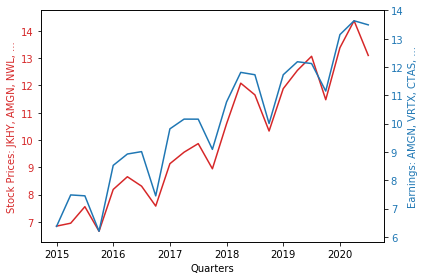

In [21]:
#plot the variates
#(if matplotlib doesn't work, may need additional jupyter code)
%matplotlib inline


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
yrs = list(range(2015,2021)) #debug
stag = ', '.join(slabel[:3])
etag = ', '.join(elabel[:3])
def plot_variates(y1=x1*w, y2=x2*e, t1=None, t2=None, lab1=f'Stock Prices: {stag}, ...', lab2=f'Earnings: {etag}, ...'): 
    
    # Pull plot data
    if t1 == None:
        t1 = stock_table.index.to_list()
        t1 = yrs #debug
        
    if t2 == None:
        t2 = earn_table.index.tolist()
        t2 = yrs #debug
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Quarters')
    ax1.set_ylabel(lab1, color=color)
    ax1.plot(y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
#    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) #cast x-axis ticks to ints
#    ax1.set_xlim(2013, 2016)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel(lab2, color=color)  # we already handled the x-label with ax1
    ax2.plot(y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    print(f'{lab1} vs {lab2}') #DEBUG
    spc = 4
    plt.xticks([0, spc ,2*spc ,3*spc, 4*spc, 5*spc], yrs) #not show too many ticks
    plt.show()

plot_variates()

For this experiment, we selecte da random subset of companies from the S&P 500. Interestingly, we observe a cyclic behavior shared by the two variates. Two out of the three overlapping companies (Amgen, Vertex) are biopharmaceutical companies. It is likely that the behavior of the two variates can be explained by a confounding variable: the cyclic sales action of biopharmaceutical companies. Even though the SCCA algorithm did not find a causal relationship, examining the primary overlap between the variates helped to highlight the biopharmaceutical companies as a leading cause of the patterns observed. 

### Experiment 2

For the second experiment, we will examine the same subset of companies, but now take a look at the earnings surprise as opposed to the estimate. This may reveal a more causaul relationship, since surprises tend to have a direct inflence on price action -- especially near earnings releases.

In [10]:
earn_surp = pull_earnings()

         DISCK__epssurprisepct
2019 Q2                  -8.49
2019 Q3                   6.10
2020 Q4                   6.18
2020 Q1                   3.45
2020 Q2                   9.22
NO MERGE
Progress: 1 / 25
         VRSN__epssurprisepct
2019 Q2                  3.26
2019 Q3                  3.66
2020 Q4                 -1.58
2020 Q1                123.96
2020 Q2                  3.69
MERGE
Progress: 2 / 25
         SBUX__epssurprisepct
2019 Q2                  7.73
2019 Q3                  0.14
2020 Q4                  4.08
2020 Q1                 -6.43
2020 Q2                 22.30
MERGE
Progress: 3 / 25
         DXCM__epssurprisepct
2019 Q2                515.38
2019 Q3                218.63
2020 Q4                 55.83
2020 Q1                207.69
2020 Q2                127.01
MERGE
Progress: 4 / 25
         CTAS__epssurprisepct
2019 Q2                  7.14
2019 Q2                  7.71
2019 Q3                 11.82
2020 Q4                  7.14
2020 Q2                 11.39

In [24]:
w,e = dual_lasso(X2=matrix(earn_surp.fillna(earn_surp.mean()).to_numpy()[:x1.size[0], :]), mu=100, gam=140)

debug (23, 25)
debug (23, 25)
A.T size:  (25, 23) b size:  (23, 1)
A.T*b =   (25, 1)
     pcost       dcost       gap    pres   dres
 0: -2.2613e+02 -8.7682e+01  5e+02  3e+01  5e-02
 1: -2.0089e+02 -3.0142e+02  2e+02  1e+01  2e-02
 2: -2.0594e+02 -2.7935e+02  9e+01  3e+00  5e-03
 3: -2.3323e+02 -2.4775e+02  2e+01  3e-01  5e-04
 4: -2.4136e+02 -2.4349e+02  2e+00  4e-02  7e-05
 5: -2.4268e+02 -2.4287e+02  2e-01  1e-03  2e-06
 6: -2.4281e+02 -2.4282e+02  1e-02  8e-05  1e-07
 7: -2.4282e+02 -2.4282e+02  4e-04  1e-06  3e-09
 8: -2.4282e+02 -2.4282e+02  1e-05  2e-08  6e-11
Optimal solution found.
A.T size:  (25, 23) b size:  (23, 1)
A.T*b =   (25, 1)
     pcost       dcost       gap    pres   dres
 0: -1.2226e+02 -6.5946e+01  2e+02  2e+01  6e-02
 1: -8.1901e+01 -1.0507e+02  2e+01  2e-15  3e-16
 2: -1.0161e+02 -1.0366e+02  2e+00  1e-15  7e-16
 3: -1.0307e+02 -1.0325e+02  2e-01  1e-15  1e-15
 4: -1.0319e+02 -1.0320e+02  1e-02  8e-16  2e-14
 5: -1.0319e+02 -1.0319e+02  5e-04  8e-16  7e-14
 6: -

In [25]:
slabel, elabel = stock_conversion(w), stock_conversion(e)
print('Closing Price Vars: ', slabel)
print('Earnings Vars: ', elabel)
print('Overlap: ', set(stock_conversion(w)) & set(stock_conversion(e)))

Closing Price Vars:  ['QCOM', 'NWL', 'VRTX', 'INCY', 'COST', 'ABMD', 'DXCM', 'IPGP', 'NFLX', 'MU']
Earnings Vars:  ['VRTX', 'TMUS', 'NWL', 'ETFC', 'ABMD', 'INCY', 'NFLX', 'FOXA', 'DXCM', 'IPGP']
Overlap:  {'IPGP', 'INCY', 'ABMD', 'NWL', 'NFLX', 'DXCM', 'VRTX'}


Stock Prices: JKHY, AMGN, NWL, ... vs Earnings: AMGN, VRTX, CTAS, ...


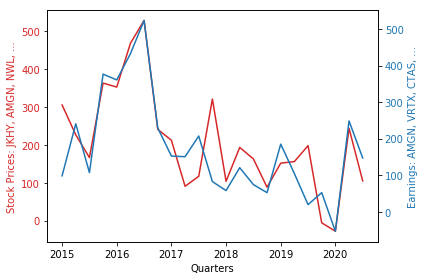

In [27]:
plot_variates(y1=x1*w, y2=matrix(earn_surp.fillna(earn_surp.mean()).to_numpy()[:x1.size[0], :])*e)

This time, the patterns captured are more reflective of overall market trends. For example, the spike we see in 2016 may point to the rise of the tech bubble, and the sharp fall and rebound in 2020 likely captures the pandemic crash. Here, we see most of the overlapping companies are those with the largest market caps in the sample. This makes intuitive sense -- we expect the largest companies where most trades are executed to have the largest influence on the market.

### Experiment 3

For the next experiment, we compare two groups of stocks. Since all the companies being examined are components of the S&P 500, one natural split is to compare the components with the highest weights to those with the lowest weights. 

In [86]:
#pull stock data
import pandas as pd
import random as rd
from glob import glob #for importing multiple csv's of same parent path
from numpy import log #default base is e (natural log)
import os.path
from os import path #to check valid file paths

#0) Pull list of SP500 tickers
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp5 = table[0]
tickers = list(sp5['Symbol'])
rd.seed(30) #use seed for reproducable experiment
stocks = rd.sample(tickers, 100)

high_weights = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'BRK.B', 'JNJ', 
                'V', 'PG', 'NVDA', 'MA', 'HD', 'JPM', 'UNH', 'ADBE', 'CRM', 
                'PYPL', 'VZ', 'NFLX', 'DIS', 'INTC', 'MRK', 'T', 'WMT', 'CMCSA', 
                'PFE', 'BAC', 'KO', 'ABT','CSCO', 'TMO', 'XOM', 'ABBV', 'MCD', 
                'COST', 'CVX', 'ACN', 'AMGN', 'MDT', 'AVGO']

low_weights = ['SEE', 'DISCK', 'HII', 'BEN', 'NWL', 'CMA', 'IPGP', 'FANG', 'FRT',
               'NWSA', 'HBI','VNO', 'FRT', 'MHK', 'ZION', 'LEG','AIV', 'NLSN', 'DXC',
               'KIM', 'FLIR', 'ALK', 'NBL', 'PBCT', 'NOV', 'FOX', 'NCLH', 'MRO', 'PVH',
               'DVN', 'TPR', 'SLG', 'UNM', 'GPS', 'FLS', 'IVZ', 'HFC', 'RL', 'XRX', 
               'DISCA', 'KSS', 'FTI', 'HRB', 'NWS', 'UAA', 'UA', 'COTY']


#finding the path
#parent_path = 'C:/Users/Zion/Desktop/CorroTrack/stooq_d_us_txt/data/daily/us/nasdaq stocks/1/' #don't need full local path
parent_path = 'stooq_d_us_txt/data/daily/us/nasdaq stocks/' #all sp500 should be on the nasdaq
alt_path = 'stooq_d_us_txt/data/daily/us/nasdaq stocks/'
def high_and_low(high=True):
    stable_ticks = set() #keep track of tickers that exist in stooq set
    count = 0
    table = pd.DataFrame()
    stocks = []
    
    if high:
        stocks = high_weights
    else:
        stocks = low_weights

    for stock in stocks:
        if path.isfile(f'{parent_path}1/{stock}.us.txt'): #if valid file path
            stock_df = pd.read_csv(f'{parent_path}1/{stock}.us.txt')
            stable_ticks.add(stock)
        elif path.isfile(f'{parent_path}2/{stock}.us.txt'): #might be in other folder
            stock_df = pd.read_csv(f'{parent_path}2/{stock}.us.txt')
            stable_ticks.add(stock)
        else: #stooq doesnt contain data
            continue
        
        stock_df.drop(['<PER>', '<TIME>', '<VOL>', '<OPENINT>'], axis=1, inplace = True)

        #computing calculated values
        stock_df['Volatility'] = (0.361*(log(stock_df['<HIGH>']) - log(stock_df['<LOW>']))**2)**(0.5)
        stock_df['Return'] = (stock_df['<CLOSE>'] - stock_df['<OPEN>'])/stock_df['<OPEN>']*100

    
        times = pd.to_datetime(stock_df['<DATE>'], format ='%Y%m%d')
        
        #3) use ticker name to change the remaining columns
        c = stock_df.pivot(index='<TICKER>', columns = '<DATE>')
        
        #rename the columns somehow (like "AUSTRIA_Liquid Fuel")
        new = c.stack(0).transpose()
        new.columns = ['__'.join(col).strip() for col in new.columns.values]
        new.index = times.dt.strftime("%Y-%m-%d") #need to do the year first so index sorts correctly
        new = new[new.index >= "2015-01-01"] #crop this 
        if table.empty:
            table = new
        else: #ready to merge
            table=pd.merge(table, new, how='outer', on='<DATE>') #CHANGE IT TO MERGE ON OUTER BUT GO 5 YRS BACK
        count += 1
        print(f'Progress: {count} / {len(stocks)}')

    #Quarter condensing
    dtimes = pd.to_datetime(table.index, format ="%Y-%m-%d")
    table.index = group_quarters(dtimes) #need to cast back to a datetime object
    table.index.name = 'quarter'
    table = table.groupby(by="quarter").mean()
    
#    order = [2,0,1] #year-month-day for sort
#    table.sort_index(key = lambda d: tuple([[int(x) for x in d.split('-')][i] for i in order]), inplace = True)
    table.sort_index(inplace = True)
    table = table.reindex(sorted(table.columns), axis=1)

    
    #filter out desired vars
#    close_prices, volatility = None, None #debug
    close_prices = table.filter(like='<CLOSE>', axis=1)
    volatility = table.filter(like='Volatility', axis=1)
#    df.filter(like='bbi', axis=0)
    
    ticks = stable_ticks.copy()
    return table, close_prices, volatility, ticks


high_table, high_cp, high_vol, high_ticks = high_and_low()
print(high_table.head())
low_table, low_cp, low_vol, low_ticks = high_and_low(high=False)
print(low_table.head())

Progress: 1 / 41
Progress: 2 / 41
Progress: 3 / 41
Progress: 4 / 41
Progress: 5 / 41
Progress: 6 / 41
Progress: 7 / 41
Progress: 8 / 41
Progress: 9 / 41
Progress: 10 / 41
Progress: 11 / 41
Progress: 12 / 41
Progress: 13 / 41
Progress: 14 / 41
Progress: 15 / 41
Progress: 16 / 41
         AAPL.US__<CLOSE>  AAPL.US__<HIGH>  AAPL.US__<LOW>  AAPL.US__<OPEN>  ...  PYPL.US__<LOW>  PYPL.US__<OPEN>  PYPL.US__Return  PYPL.US__Volatility
quarter                                                                      ...                                                                       
2015 Q1        117.446250       118.398906      116.630938       117.593906  ...             NaN              NaN              NaN                  NaN
2015 Q2        108.201094       109.537344      106.859953       108.315469  ...       35.379758        36.295968        -0.941202             0.023046
2015 Q3        105.901969       106.880172      104.852125       105.943656  ...       34.693294        35.226406

In [87]:
x1 = matrix(low_cp.fillna(low_cp.mean()).to_numpy()) #(23, 13)
x2 = matrix(high_cp.fillna(high_cp.mean()).to_numpy()[:, :x1.size[1]])

w,e = dual_lasso(X1=x1, X2=x2, mu=100, gam=140)


debug (23, 12)
debug (23, 12)
A.T size:  (12, 23) b size:  (23, 1)
A.T*b =   (12, 1)
     pcost       dcost       gap    pres   dres
 0: -1.6866e+04 -1.5694e+04  4e+03  7e+01  4e-02
 1: -1.7519e+04 -1.8748e+04  2e+03  2e+01  1e-02
 2: -1.7620e+04 -1.7962e+04  4e+02  4e+00  2e-03
 3: -1.7683e+04 -1.7762e+04  8e+01  6e-14  1e-14
 4: -1.7739e+04 -1.7742e+04  4e+00  1e-14  2e-14
 5: -1.7741e+04 -1.7741e+04  9e-02  1e-14  1e-14
 6: -1.7741e+04 -1.7741e+04  9e-04  6e-14  6e-14
Optimal solution found.
A.T size:  (12, 23) b size:  (23, 1)
A.T*b =   (12, 1)
     pcost       dcost       gap    pres   dres
 0: -8.9833e+03 -8.9211e+03  3e+02  2e+01  1e-03
 1: -8.9615e+03 -9.0032e+03  5e+01  2e+00  2e-04
 2: -8.9821e+03 -8.9872e+03  5e+00  4e-15  9e-15
 3: -8.9861e+03 -8.9864e+03  2e-01  4e-15  2e-14
 4: -8.9863e+03 -8.9863e+03  9e-03  4e-15  6e-14
 5: -8.9863e+03 -8.9863e+03  1e-04  4e-15  2e-13
Optimal solution found.
A.T size:  (12, 23) b size:  (23, 1)
A.T*b =   (12, 1)
     pcost       dcost  

In [88]:
hticks = list(high_ticks)
hticks.sort()
lticks = list(ticks)
lticks.sort()

slabel, elabel = stock_conversion(w, hticks), stock_conversion(e, lticks)
print('Closing Price Vars: ', slabel)
print('Earnings Vars: ', elabel)

Closing Price Vars:  ['AMZN', 'COST', 'AMGN', 'CSCO', 'AVGO', 'CMCSA']
Earnings Vars:  ['DISCK', 'NWSA', 'DISCA', 'FLIR', 'NBL']


Stock Prices: AMZN, COST, AMGN, ... vs Stock Prices: DISCK, NWSA, DISCA, ...


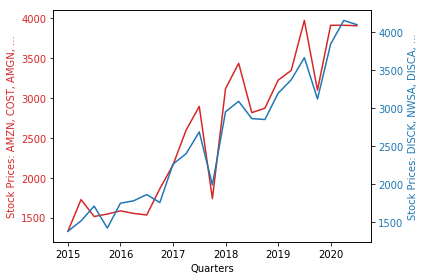

In [94]:
x1 = matrix(low_cp.fillna(low_cp.mean()).to_numpy()) #(23, 13)
x2 = matrix(high_cp.fillna(high_cp.mean()).to_numpy()[:, :x1.size[1]])

stag = ', '.join(slabel[:3])
etag = ', '.join(elabel[:3])
plot_variates(y1=x1*w, y2=x2*e, lab1=f'Stock Prices: {stag}, ...', lab2=f'Stock Prices: {etag}, ...')


This is the first analysis where the sets of companies being compared are completely disjoint. Even so, the algorithm correlates companies from similar sectors. Most of the low-weight component stocks (DISCK, NWSA, DISCA) are media/telecomm companies. Many of the high-weight stocks (CMCSA, AVGO, AMZN) also produce goods/services which support mass media/telecomm directly, or the infastructure and techonology behind it. In this way, the algorithm was able to point towards broader industry/market trends through this example.

### Experiment 4

Since a significant component of finance is risk, financial analysts are often interested in examining volatility of different stocks. In our final experiment, we will explore stock volatility by comparing it to the magnitude of earnings surprise. For data pulling, we will examine the same random S&P 500 companies that we examined in Experiment 1.  

In [131]:
x1 = matrix(vol.fillna(vol.mean()).to_numpy())
emag = earn_surp.abs()
x2 =  matrix(emag.fillna(emag.mean()).to_numpy()[:x1.size[0], :])

w,e = dual_lasso(X1=x1, X2=x2, mu=4, gam=100) #5, 40

debug (23, 25)
debug (23, 25)
A.T size:  (25, 23) b size:  (23, 1)
A.T*b =   (25, 1)
     pcost       dcost       gap    pres   dres
 0: -2.6579e+03  2.4411e+02  3e+03  8e+01  1e+00
 1: -1.1068e+04 -9.9043e+03  3e+03  7e+01  1e+00
 2: -1.6094e+04 -1.5132e+04  4e+03  7e+01  1e+00
 3: -6.4194e+04 -7.7926e+04  2e+04  6e+01  1e+00
 4: -1.1899e+05 -1.4920e+05  3e+04  2e+00  4e-02
 5: -1.1505e+05 -1.3232e+05  2e+04  1e+00  2e-02
 6: -1.1706e+05 -1.5029e+05  3e+04  7e-01  1e-02
 7: -1.2187e+05 -1.3629e+05  1e+04  3e-01  5e-03
 8: -1.2348e+05 -1.2990e+05  6e+03  5e-12  1e-15
 9: -1.2765e+05 -1.2820e+05  6e+02  4e-12  2e-16
10: -1.2809e+05 -1.2810e+05  8e+00  2e-12  2e-16
11: -1.2809e+05 -1.2809e+05  8e-02  1e-11  2e-16
Optimal solution found.
A.T size:  (25, 23) b size:  (23, 1)
A.T*b =   (25, 1)
     pcost       dcost       gap    pres   dres
 0: -2.0692e+02 -1.4404e+02  2e+02  2e+01  3e-02
 1: -1.6833e+02 -1.9402e+02  3e+01  1e+00  3e-03
 2: -1.8338e+02 -1.8631e+02  3e+00  9e-02  2e-04
 3: -

In [132]:
slabel, elabel = stock_conversion(w), stock_conversion(e)
print('Closing Price Vars: ', slabel)
print('Earnings Vars: ', elabel)
print('Overlap: ', set(stock_conversion(w)) & set(stock_conversion(e)))

Closing Price Vars:  ['HBAN', 'INCY', 'MYL', 'MU']
Earnings Vars:  ['DISCK', 'ETFC', 'NWL', 'ODFL', 'IPGP', 'VRSN', 'HBAN', 'NFLX', 'FOXA', 'TMUS', 'VRTX', 'DXCM', 'ABMD', 'INCY']
Overlap:  {'INCY', 'HBAN'}


Volatility: HBAN, INCY, MYL, ... vs Earning Surprise: DISCK, ETFC, NWL, ...


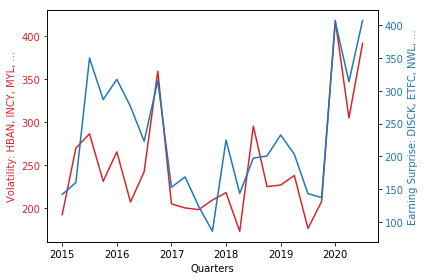

In [133]:
stag = ', '.join(slabel[:3])
etag = ', '.join(elabel[:3])
plot_variates(y1=x1*w, y2=x2*e, lab1=f'Volatility: {stag}, ...', lab2=f'Earning Surprise: {etag}, ...')

These results are the most difficult to interpret of all of the experiments so far -- possibly because the data points are derivative values rather than direct directly extracted ones. As one might predict, the volatility and earnings surprise fluctuate quarter-to-quarter, so there are no apparent persisting trends. One interesting find -- it is more difficult to enforce sparsity in the earnings surprise, perhaps because the surprise magnitude is similar across the companies in the subset. <br> <br>

More experiments comparing volatility with earnings surprise are needed to find more conclusive trends. The results we see here could be an artifact of the data samples, the algorithm, or some combination of the two. 